# Predicting Pokemon Types

This project will focus on predicting Pokemon types based on supervised learning models. In particular, we will take advantage of the following:

- Naives Bayes
- Support Vector Machines
- Random Forest

- K-folds Cross Validation
- Leave-one-out Cross Validation

- Parameter Tuning with GridSearchCV

In [52]:
# Import initial libraries and settings
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
%pylab inline

pylab.rcParams['figure.figsize'] = (12.0, 11.0)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Setting up my directory
os.chdir('C:/Users/Kevin/Desktop/Dropbox/Dropbox/Brainstation - Project/')
#os.chdir('C:/Users/knguyen/Dropbox/Brainstation - Project/')

# Import data
df = pd.read_csv('Pokemon.csv')
df2 = pd.read_csv('pokemon_stats.csv')

# Data Cleaning and Merging

In [4]:
# To ensure consistency between datasets
df['Name'] = df['Name'].str.lower()

# Fix name issues between datasets
df = df.replace({'Name': {'nidoran♀': 'nidoran-f', 'nidoran♂': 'nidoran-m', "farfetch'd": 'farfetchd',
                                'mr. mime': 'mr-mime', 'deoxysnormal forme': 'deoxys-normal', 'wormadamplant cloak': 'wormadam-plant',
                                'mime jr.': 'mime-jr', 'giratinaaltered forme': 'giratina-altered', 'shayminland forme': 'shaymin-land',
                                'basculin': 'basculin-red-striped', 'darmanitanstandard mode': 'darmanitan-standard',
                                'tornadusincarnate forme': 'tornadus-incarnate', 'thundurusincarnate forme': 'thundurus-incarnate',
                                'landorusincarnate forme': 'landorus-incarnate', 'keldeoordinary forme': 'keldeo-ordinary',
                                'meloettaaria forme': 'meloetta-aria', 'flabébé': 'flabebe', 'meowsticmale': 'meowstic-male',
                                'aegislashshield forme': 'aegislash-shield', 'pumpkabooaverage size': 'pumpkaboo-average',
                                'gourgeistaverage size': 'gourgeist-average', 'hoopahoopa confined': 'hoopa'}})

# Merge both datasets
df_merged = pd.merge(df, df2, left_on='Name', right_on='identifier', how='left')

# Drop unnecessary rows and columns
df_merged = df_merged[df_merged['is_default'] == 1]
cols_to_keep = ['Name', 'Type 1', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
                'Generation', 'Legendary', 'height', 'weight', 'base_experience']
df_merged = df_merged[cols_to_keep]

In [5]:
# View the data
df_merged.head(5)

,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience
0,bulbasaur,Grass,318,45,49,49,65,65,45,1,False,7.0,69.0,64.0
1,ivysaur,Grass,405,60,62,63,80,80,60,1,False,10.0,130.0,142.0
2,venusaur,Grass,525,80,82,83,100,100,80,1,False,20.0,1000.0,236.0
4,charmander,Fire,309,39,52,43,60,50,65,1,False,6.0,85.0,62.0
5,charmeleon,Fire,405,58,64,58,80,65,80,1,False,11.0,190.0,142.0


# Data Visualizations

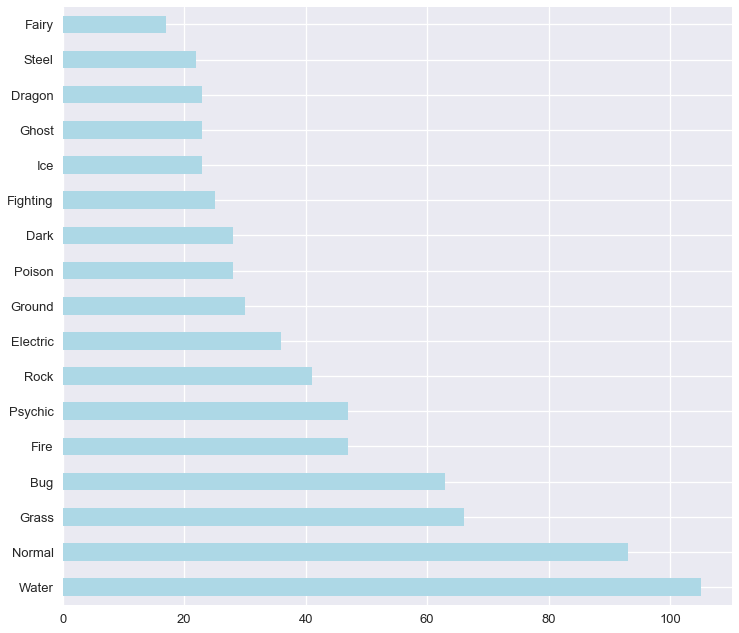

In [53]:
# What is the proportion of each type in our dataset?
df_merged['Type 1'].value_counts().plot(kind='barh', color='lightblue')

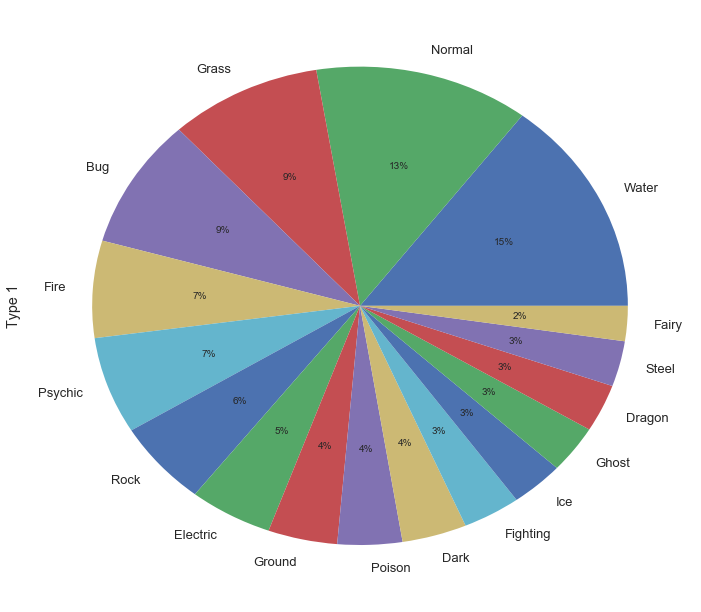

In [54]:
# Lets view the proportion by %'s instead
labels = df_merged['Type 1'].value_counts().index
df_merged['Type 1'].value_counts().plot(kind='pie', labels=labels, autopct='%1.0f%%')

In [8]:
# There is 0% flying types! (rounded) - who are they?
df_merged[df['Type 1'] == 'Flying']

C:\Users\Kevin\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience
702,tornadus-incarnate,Flying,580,79,115,70,125,80,111,5,True,15.0,630.0,261.0
790,noibat,Flying,245,40,30,35,45,40,55,6,False,5.0,80.0,49.0
791,noivern,Flying,535,85,70,80,97,80,123,6,False,15.0,850.0,187.0


Domain knowledge tells us Noibat and its evolution are the only Pokemon with flying as their main type.
In addition, they are actually the weakest pokemon with "dragon" types.
Let us remove the flying types

In [9]:
df_merged = df_merged[df_merged['Type 1'] != 'Flying']

In [10]:
# Which Pokemon has the highest value for each stat?
variables_list = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'height', 'weight', 'base_experience']

for i in variables_list:    
    print(df_merged.groupby(['Name'], as_index=False)['%s' % i].max().sort_values(by=['%s' % i], ascending=False).head(3))

       Name  Total
18   arceus    720
139  dialga    680
397  mewtwo    680
          Name   HP
55     blissey  255
84     chansey  250
696  wobbuffet  190
          Name  Attack
493  rampardos     165
499  regigigas     160
566    slaking     160
         Name  Defense
552   shuckle      230
599   steelix      200
500  regirock      200
       Name  Sp. Atk
397  mewtwo      154
139  dialga      150
439  palkia      150
        Name  Sp. Def
552  shuckle      230
498   regice      200
204  florges      154
              Name  Speed
427        ninjask    160
136  deoxys-normal    150
3         accelgor    145
        Name  height
682  wailord   145.0
599  steelix    92.0
436     onix    88.0
                 Name  weight
255           groudon  9500.0
229  giratina-altered  7500.0
139            dialga  6830.0
       Name  base_experience
55  blissey            608.0
84  chansey            395.0
26   audino            390.0


### Strongest Overall: 
<img src="https://cdn.bulbagarden.net/upload/thumb/f/fc/493Arceus.png/600px-493Arceus.png", alt="Drawing", style="width: 200px;"/>

### Strongest Attack
<img src="https://cdn.bulbagarden.net/upload/8/8a/409Rampardos.png", alt="Drawing", style="width: 200px;"/>

### Strongest Special Attack
<img src="https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/600px-150Mewtwo.png", alt="Drawing", style="width: 200px;"/>

### Strong Defense + Special Defense
<img src="https://cdn.bulbagarden.net/upload/thumb/c/c7/213Shuckle.png/600px-213Shuckle.png", alt="Drawing", style="width: 200px;"/>

### Tallest
<img src="https://cdn.bulbagarden.net/upload/b/b9/321Wailord.png", alt="Drawing", style="width: 200px;"/>

### Most Experience when Defeated
<img src="https://cdn.bulbagarden.net/upload/thumb/5/56/242Blissey.png/600px-242Blissey.png", alt="Drawing", style="width: 200px;"/>

### What is my favourite Pokemon?

Hints: Grass

Generation 2

Cuddly

Has a leaf on its head

Is the "Bulbasaur" of generation 2

<img src="https://cdn.bulbagarden.net/upload/thumb/b/bf/152Chikorita.png/600px-152Chikorita.png", alt="Drawing", style="width: 200px;"/>

In [11]:
# Who is the 'strongest' Pokemon of each type?
strongest = df_merged.sort_values(by='Total', ascending=False)
strongest.drop_duplicates(subset=['Type 1'], keep='first')

,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,height,weight,base_experience
552,arceus,Normal,720,120,120,120,120,120,120,4,True,32.0,3200.0,324.0
707,zekrom,Dragon,680,100,150,120,120,100,90,5,True,29.0,3450.0,306.0
270,ho-oh,Fire,680,106,130,90,110,154,90,2,True,38.0,1990.0,306.0
544,giratina-altered,Ghost,680,150,100,120,100,120,90,4,True,45.0,7500.0,306.0
541,palkia,Water,680,90,120,100,150,120,100,4,True,42.0,3360.0,306.0
540,dialga,Steel,680,100,120,120,150,100,90,4,True,54.0,6830.0,306.0
793,yveltal,Dark,680,126,131,95,131,98,99,6,True,58.0,2030.0,306.0
792,xerneas,Fairy,680,126,131,95,131,98,99,6,True,30.0,2150.0,306.0
162,mewtwo,Psychic,680,106,110,90,154,90,130,1,True,20.0,1220.0,306.0
423,groudon,Ground,670,100,150,140,100,90,90,3,True,35.0,9500.0,302.0


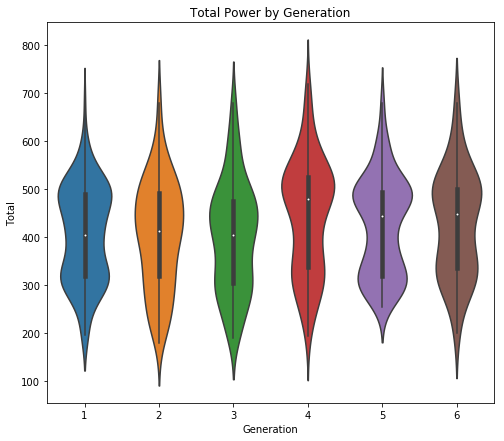

In [12]:
# How powerful is each generation
plt.title('Total Power by Generation')
sns.violinplot(x = 'Generation', y='Total', data=df_merged)

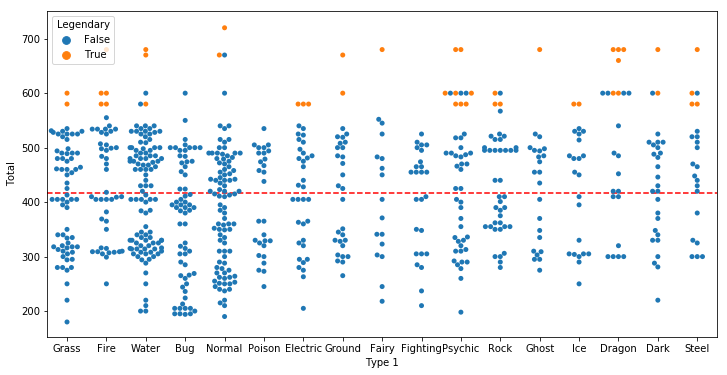

In [13]:
# Where do legendaries fall within the power level in each type?
plt.figure(figsize=(12,6))
sns.swarmplot(x='Type 1', y='Total', data=df_merged, hue='Legendary')
plt.axhline(df_merged['Total'].mean(), color='red', linestyle='dashed')

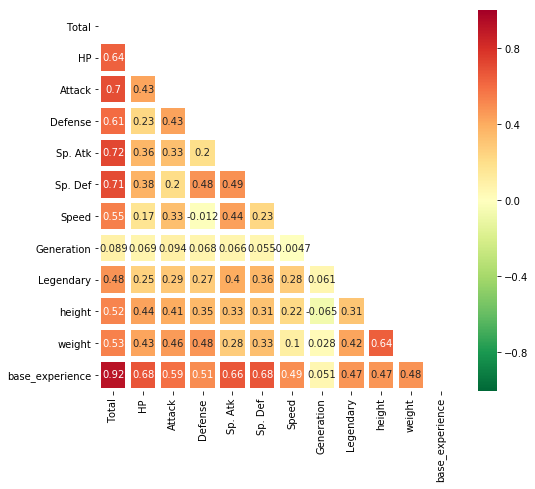

In [14]:
# Are the variables correlated to each other?
corr_df = df_merged.corr(method='pearson')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=4.5, annot=True)

# Prepping Training and Testing Data

In [15]:
# Set legendary False = 0, True = 1
df_merged['Legendary'] = np.where(df_merged['Legendary'] == True, 1, 0)

In [16]:
# Remove out a random sample of 5% of EACH TYPE of pokemon to be used as the test data
type_list = list(df_merged['Type 1'].unique())

df_test = pd.DataFrame(columns = df_merged.columns)
for i in type_list:
    df_test = df_test.append((df_merged[df_merged['Type 1'] == i]).sample(frac=0.05))

In [17]:
# Now remove the sample rows from the main dataset
df_train = df_merged[~df_merged['Name'].isin(df_test['Name'])]

In [18]:
# Standardize and scale our numeric data
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()

X_train = max_abs_scaler.fit_transform(df_train.iloc[:,2:13])
X_test = max_abs_scaler.fit_transform(df_test.iloc[:,2:13])

In [19]:
# Create an arrays for our labels
array_train = df_train.values
array_test = df_test.values

Y_train = array_train[:,1]
Y_test = array_test[:,1]

# Algorithm One: Naives Bayes

In [23]:
# Import Naives Bayes and 10-fold cross validation
from sklearn import model_selection

# Prepare the kfold model
kfold = model_selection.KFold(n_splits=10, shuffle=True)

# Leave one out cross validation model
loocv = model_selection.LeaveOneOut()

In [24]:
# Train the Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB(priors=None)

In [25]:
# Naives Bayes with Kfolds on our Test Data
results = model_selection.cross_val_score(gnb, X_test, Y_test, cv=kfold)
results.mean()

0.091666666666666646

In [26]:
# Naive Bayes with LOOCV on our Test Data
results2 = model_selection.cross_val_score(gnb, X_test, Y_test, cv=loocv)
results2.mean()

0.058823529411764705

# Algorithm Two: Support Vector Machines (SVM)

In [27]:
# Import SVM
from sklearn.svm import SVC
from sklearn import svm
estimator = SVC(kernel='linear')

# Let us conduct parameter tuning with GridSearchCV to optimize our results
from sklearn.model_selection import GridSearchCV

In [28]:
# Prep up parameters to tune
svm_parameters = [
                  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
                  ]

In [40]:
# Train our SVM classifier                  
svm_classifier = GridSearchCV(estimator=estimator, cv=kfold, param_grid=svm_parameters)
svm_classifier.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
# The best parameters with the score:
print('Best score for data:', svm_classifier.best_score_)
print('Best C:',svm_classifier.best_estimator_.C) 
print('Best Kernel:',svm_classifier.best_estimator_.kernel)
print('Best Gamma:',svm_classifier.best_estimator_.gamma)

Best score for data: 0.235724743777
Best C: 100
Best Kernel: linear
Best Gamma: auto


In [42]:
# Test our trained SVM classifier with our test data
svm_classifier.score(X_test, Y_test)

0.23529411764705882

# Algorithm Three - Random Forest

In [32]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Prep parameters and the Random Forest classifier
forest_clf = RandomForestClassifier()
forest_parameters = {
                        "max_features": [2, 5, 10, 'auto'],
                        "n_estimators": [50, 100, 200],
                        "criterion": ["gini", "entropy"],
                        "min_samples_leaf": [1,2,4,6],
                    }
                    
forest_classifier = GridSearchCV(estimator=forest_clf, param_grid=forest_parameters)

In [49]:
# Train our Random Forest Classifier - This will take very long to run!
forest_classifier.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [2, 5, 10, 'auto'], 'criterion': ['gini', 'entropy'], 'n_estimators': [50, 100, 200], 'min_samples_leaf': [1, 2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
# The best parameters with the score:
print('Best score:', forest_classifier.best_score_)
print('Best Max_Features:', forest_classifier.best_estimator_.max_features)
print('Best N_estimators:', forest_classifier.best_estimator_.n_estimators)
print('Best criterion:', forest_classifier.best_estimator_.criterion)
print('Best Min_samples_leaf:', forest_classifier.best_estimator_.min_samples_leaf)

Best score: 0.244509516837
Best Max_Features: 2
Best N_estimators: 100
Best criterion: entropy
Best Min_samples_leaf: 4


In [45]:
# Test our trained Random Forest classifier with our test data
forest_classifier.score(X_test, Y_test)

0.14705882352941177

## Computational Difficulty

Our three algorithms had varying results and time to train. Lets take a look at how long each algorithm took to train, with their overall score:

In [46]:
import time
start_time = time.time()
gnb.fit(X_train, Y_train)
print("Naive Bayes took", time.time() - start_time, "seconds to train.")

Naive Bayes took 0.0024836063385009766 seconds to train.


In [47]:
start_time = time.time()
svm_classifier.fit(X_train, Y_train)
print("SVM took", time.time() - start_time, "seconds to train.")

SVM took took 8.379002571105957 seconds to train.


In [48]:
start_time = time.time()
forest_classifier.fit(X_train, Y_train)
print("Random Forest took", time.time() - start_time, "seconds to train.")

Random Forest took 62.11705303192139 seconds to train.


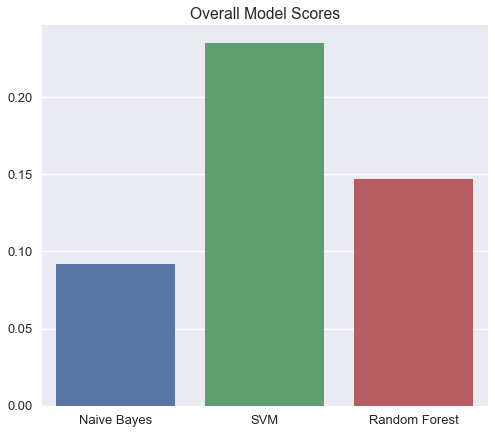

In [50]:
labels = ['Naive Bayes', 'SVM', 'Random Forest']
scores = [0.092, 0.235, 0.147]
train_time = [0.002, 8.379, 62.117]

# Overall Score
sns.set(style="darkgrid", context="talk")
ax = plt.axes()
ax.set_title("Overall Model Scores")
sns.barplot(labels, scores, ax=ax);

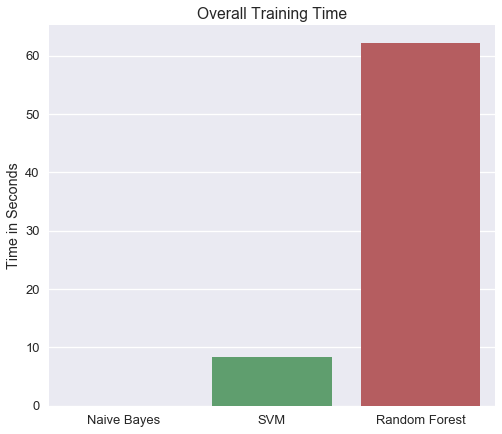

In [51]:
# Overall Computing Time
sns.set(style="darkgrid", context="talk")
ax = plt.axes()
ax.set_title("Overall Training Time")
ax.set_ylabel("Time in Seconds")
sns.barplot(labels, train_time, ax=ax);

# Algorithm Conclusions

There is a signficant performance boost when comparing SVM to Naives Bayes. While Random Forest undoubtly the most computationally expensive, it did not performance as well as SVM.

These models give a classic example and lesson on valuing difficulty vs. results. Our Naives Bayes algorithm took about 0.002 seconds to run compared to a massive 62 seconds for Random Forest. This dataset was extremely tiny, in a real-world situation, these models and features would need to be heavily optimized.

Please note there was little optimization done with each algorithm as this was not the focus of the project!